---
# NOTEBOOK 3 - FEATURE ENGINEERING PART 2:
## Create Distance to Public Transit Feature
---

# PROJECT : Boston Airbnb Fair Pricing Tool and Recommender

# Notebook Overview and Data Sources:
The purpose of this notebook is to gather locations of public transit subway stops in the Boston area and calculate the distance between each listing location and its closest transit stop.  In Boston, the subway is called 'The T' and the stops are locations where the trains will stop to pick up passengers.  It shoud here be noted that ONLY T-stops are considered as finding all bus stops is not feasible.  The motivation in doing this is to explore whether or not a closer proximity to the public transit would increase the value/price of an Airbnb listing, especially considering Boston's limited parking, confusing roadways, and notoriously aggressive drivers (I'm from Massachusetts so I can confirm this).


Latitude and longitude data are provided for each listing, and the subway stop locations were gathered via the following method:
* The [MBTA Stations](https://www.mbta.com/stops/subway) page was scraped to find all urls for all stations
* Station site was then scraped to find the station address
* The Google Geocoding API was then used to retrieve latitude and longitude for each address.  See the documentation [here](https://developers.google.com/maps/documentation/geocoding)

### Calculating 'Distances' to T-Stops
For simplicity the 'distance' was directly calculated as the Euclidean distances between the latitude and longitude coordinates for the stations and listings.  This is not an actual distance measured in standard units of length as latitude and longitude do not correspond to standard distance measures and can vary depending on location.  The following assumptions were made to allow this:
* The Boston area is contained within a 15-mile radius, which compared to the approximately 8,000-mile diameter planet earth, is very small.  With this, angular displacements represented by latitude and longitude angular difference are assumed to sufficiently correspond to relatively constant changes in distance
    * It must be noted that one degree of longitudinal displacement is NOT equal to one degree of displacement in latitude at the average latitude of the Boston Airbnb listings of 42.3 deg.  A correction factor approximately equaling 0.74 will be applied to the longitude data when computing the distances
* The distances are calculated as Euclidean distances to provide a simple and rough estimate of how far away the nearest T-stop is for each listing and ignores street paths and roads

# NOTE REGARDING GOOGLE GEOCODING API DATA
The data collected via the Geocoding API are not pushed to GitHub as Google appears to have restrictions on the data obtained.  The [Google Maps Platform Terms of Service](https://cloud.google.com/maps-platform/terms?_gl=1*1v1wn86*_ga*NjA0MzgzMTI1LjE2ODU4NjA1NTU.*_ga_NRWSTWS78N*MTY4NjMyODIwNy44LjEuMTY4NjMyODQ3MS4wLjAuMA..), section 3.2.3(a) does not appear to permit the user to '(i) pre-fetch, index, store, reshare, or rehost Google Maps Content outside the services.'  This may imply that storing the geocoding data outside of this local machine where others can access it, is not allowed.

Thus, while it's not fully clear why Google would offer these services but disallow the publication of its already-publicly available data, the geocode data will be omitted from the public repo.

# 1 - Library Imports and Read-in Data

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Math for help with distances
import math

# Import the config file
import config

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# for Google Geocoding API
'''
Setting up the API key and getting started was enabled with help from the following sources:
* https://developers.google.com/maps/documentation/geocoding/?csw=1
* https://developers.google.com/maps/documentation/geocoding/overview
* https://developers.google.com/maps/get-started#api-key
* https://developers.google.com/maps/documentation/geocoding/get-api-key
* https://github.com/googlemaps/google-maps-services-python
'''
import googlemaps
from datetime import datetime

# Import the Beatiful Soup and Requests Packages for web scraping:
import requests
from bs4 import BeautifulSoup

# Need to import time to add waits/pauses:
import time

In [2]:
# Read in the data
lstn = pd.read_csv('../data/listings_train_2.csv')

In [3]:
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2781 non-null   int64  
 1   name                                          2781 non-null   object 
 2   description                                   2769 non-null   object 
 3   neighborhood_overview                         1803 non-null   object 
 4   host_id                                       2781 non-null   int64  
 5   host_since                                    2781 non-null   float64
 6   host_location                                 2152 non-null   object 
 7   host_about                                    1977 non-null   object 
 8   host_response_time                            2781 non-null   object 
 9   host_response_rate                            2781 non-null   f

# 2 - Copy Over Necessary Functions From Previous Notebooks
The functions below have been copied over from previous notebookd as they will be useful here.

In a subsequent phase, these should be added to a .py file.

In [4]:
'''
The col_logger function will need to be brough in from the other notebooks

This has been modified to include a 0 imputation value n such that transforamtion
occurs on log(n) and not log(0) which is undefined.
'''

def col_logger(data_column, zero_imp = 1):
    # Since log(0) is undefined, 0's must be treated as log(1)
    return data_column.apply(lambda x: np.log(zero_imp) if x==0 else np.log(x))

In [5]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions must match
    #  To do that, indices will be compared to get the intersection of index values
    #  Help with this from:  https://realpython.com/numpy-scipy-pandas-correlation-python/#pearson-correlation-coefficient
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    y_log_corr = round(pd.DataFrame([data_x, col_logger(data_y)]).T.corr().iloc[0][1], 3)
    x_y_log_corr = round(pd.DataFrame([col_logger(data_x), col_logger(data_y)]).T.corr().iloc[0][1], 3)
    
    plt.figure(figsize = size)
    
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    # For log scaale, source for help:  https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/
    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}\ncorr: {y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}\ncorr: {x_y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

# 3 - Find Proximity to Subway ('T') Stations

## 3.1 - Get a List of All the T Stations/Stops

The site listed previously qill be scraped to get the list of stations's urls.  Each url will then be scraped for the address.

In [6]:
# Store the base url from which all T-stop data will be retrieved
base_url = 'https://www.mbta.com/stops/subway'

# Connect to the web page:
res = requests.get(base_url)

# Pull the website text HTML string out
html = res.text

# Create that Beautiful Soup Instance!  Choosing 'lxml' as the parser.
soup = BeautifulSoup(html, 'lxml')

res.status_code

200

In [7]:
# From the site code, the urls for the stops are under the class specified below
a_list = soup.find_all('a', {'class': 'btn button stop-btn m-detailed-stop'})

# The href is then the url for each stop
stn_urls = [station['href'] for station in a_list]
print(len(stn_urls))
stn_urls

132


['/stops/place-alfcl',
 '/stops/place-andrw',
 '/stops/place-asmnl',
 '/stops/place-brntn',
 '/stops/place-brdwy',
 '/stops/place-cntsq',
 '/stops/place-chmnl',
 '/stops/place-davis',
 '/stops/place-dwnxg',
 '/stops/place-fldcr',
 '/stops/place-harsq',
 '/stops/place-jfk',
 '/stops/place-knncl',
 '/stops/place-nqncy',
 '/stops/place-pktrm',
 '/stops/place-portr',
 '/stops/place-qamnl',
 '/stops/place-qnctr',
 '/stops/place-shmnl',
 '/stops/place-smmnl',
 '/stops/place-sstat',
 '/stops/place-wlsta',
 '/stops/place-asmnl',
 '/stops/place-butlr',
 '/stops/place-capst',
 '/stops/place-cedgr',
 '/stops/place-cenav',
 '/stops/place-matt',
 '/stops/place-miltt',
 '/stops/place-valrd',
 '/stops/place-astao',
 '/stops/place-bbsta',
 '/stops/place-chncl',
 '/stops/place-ccmnl',
 '/stops/place-dwnxg',
 '/stops/place-forhl',
 '/stops/place-grnst',
 '/stops/place-haecl',
 '/stops/place-jaksn',
 '/stops/place-mlmnl',
 '/stops/place-masta',
 '/stops/place-north',
 '/stops/place-ogmnl',
 '/stops/place

In [8]:
# Create the url for the station

'''
For whatever reason, the base url for each specific station drops the '/stops/subway'
portion of the base url.  This is corrected by creating a new base url
'''
# Create the new base url
base_url_new = base_url.replace('/stops/subway', '')
print(base_url_new)

# Now take everything above and loop through it but add a wait time
    # Source:  https://stackoverflow.com/questions/24409861/tell-python-to-wait-pause-a-for-loop

add_list = []
    
for station in stn_urls:
    # Create the url for the first T-stop
    stn_url = base_url_new + station

    # Connect to T-stop page
    res_stn = requests.get(stn_url)

    # Pull the website text HTML string out for the station/t-stop
    html_stn = res_stn.text

    # Create the soup object
    soup_stn = BeautifulSoup(html_stn, 'lxml')

    # Extract the address text:
    add_list.append(soup_stn.find_all('div', {'class': 'h3'})[0].text)
    
    # Add a wait time of 1 second
    time.sleep(1)

https://www.mbta.com


In [9]:
# Store the data to a dataframe and save as a .csv in-case you get blocked
#  after needing to rerun this code multiple times.
t_stop_adrs = pd.DataFrame(pd.Series(add_list), columns = ['address'])
t_stop_adrs.to_csv('../data/t_stop_addresses.csv', index = False)

## 3.2 - Geocoding API

In [10]:
# I think we need this url per the following source:
#  https://developers.google.com/maps/documentation/geocoding/get-api-key

# This is the url they give you for formatting:
    # 'https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA&key=YOUR_API_KEY'
api_key = config.api_key;

### 3.2.1 - Test Out a Request

In [11]:
# The code below was copied exactly from the following source, just ot make sure that it works:
    # https://github.com/googlemaps/google-maps-services-python

gmaps = googlemaps.Client(key=api_key)

# Geocoding an address
geocode_result = gmaps.geocode('Alewife Brook Pkwy and Cambridge Park Dr, Cambridge, MA 02140')

In [12]:
# View the Result
geocode_result

[{'address_components': [{'long_name': 'Alewife Brook Parkway & Cambridgepark Drive',
    'short_name': 'Alewife Brook Pkwy & Cambridgepark Dr',
    'types': ['intersection']},
   {'long_name': 'North Cambridge',
    'short_name': 'North Cambridge',
    'types': ['neighborhood', 'political']},
   {'long_name': 'Cambridge',
    'short_name': 'Cambridge',
    'types': ['locality', 'political']},
   {'long_name': 'Middlesex County',
    'short_name': 'Middlesex County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Massachusetts',
    'short_name': 'MA',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']},
   {'long_name': '02140', 'short_name': '02140', 'types': ['postal_code']}],
  'formatted_address': 'Alewife Brook Pkwy & Cambridgepark Dr, Cambridge, MA 02140, USA',
  'geometry': {'location': {'lat': 42.3947455, 'lng': -71.14048149999999},
   'locati

In [13]:
# Here, the latitude and longitude can be extracted:
#  Help with selecting the appropriate coordinates from:  https://stackoverflow.com/questions/43194789/whats-the-difference-between-location-and-viewport-coordinates-when-geocoding-wi
geocode_result[0]['geometry']['location']

{'lat': 42.3947455, 'lng': -71.14048149999999}

## 3.3 - Create a Loop to Perform All Requests and Extract Lat/Long Data

In [14]:
# Geocode each address and store the results to a list

# Create an empty list to store the geodata:
geocode_res = []

for station in add_list:
    
    # Input the address and search
    stn_geocode_result = gmaps.geocode(station)
    
    # Append to a list
    geocode_res.append(stn_geocode_result)
    
    # Add a wait time
    time.sleep(0.1)

In [15]:
# Unpack the latitude and longitude
latitudes = [place[0]['geometry']['location']['lat'] for place in geocode_res]
longitudes = [place[0]['geometry']['location']['lng'] for place in geocode_res]

In [16]:
# Create a dataframe and store the data to a .csv for the same reasons as the addresses
lat_lng_df = pd.DataFrame(np.array([latitudes, longitudes]), index = ['lat', 'long']).T
lat_lng_df.to_csv('../data/lat_lng_data.csv', index = False)

# 4 - Calculate Euclidean Distinaces to T-Stops

In [17]:
# This funciton was written around the following source:
# https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d

def min_dist(fn_lat, fn_lng, lat_data, lng_data):
    
    '''
    The average latitude of all Boston Airbnb listings is about 42.3 degrees.  At this latitude,
    one degree of latitude is a larger distance than one degree of longitude.  Thus, if the
    latitude and longitude angular displacements between two locations are equal, their distances
    are not.  A distance correction factor needs to be added in to correct this discrepancy.  It
    will be multiplied by the longitude values to get latitidue and longitude in the same equivalent
    distance scale.
    '''
    
    # Source for calculating cosine
    # https://www.geeksforgeeks.org/python-math-cos-function/
    # Source for pi:  https://www.w3schools.com/python/ref_math_pi.asp
    dist_correction_factor = math.cos(42.3*math.pi/180)
    
    # Set a minimum distnace well beyond anything that would be derived
    min_dist = 90
    
    # Write a loop to find the minimum (euclidean) distance to every T-stop
    for n in range(len(latitudes)):
        dist = ((fn_lat - lat_data[n])**2 + (dist_correction_factor * (fn_lng - lng_data[n]))**2)**0.5
        
        # Store this distance if smaller than min distance
        if dist < min_dist:
            min_dist = dist
    
    return min_dist

In [18]:
# Crate a new column with the minimum distance to any T-stop
#  The following source was used to help write this code (note axis = 1 is KEY!):
    # https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d
lstn['min_distance'] = lstn.apply(lambda x: min_dist(x.latitude, x.longitude, latitudes, longitudes), axis = 1)

# 5 - Plot Minimum Distance vs. Price and Calculate Correlations

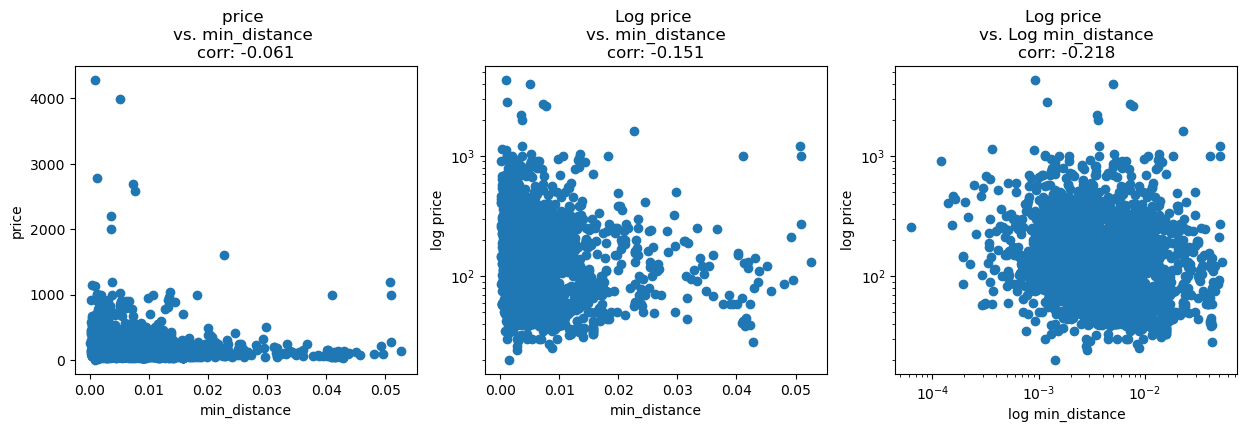

In [19]:
# PLot the price versus the minimum distance to a T-stop
plot_vs_log(lstn['min_distance'], lstn.price)

## 5.1 - Observations:
* Correlations between minimum t_stop distance and log price are very weak
* Correlations between log distance and log price are only slightly better

These data will be incorporated in the following notebook.